In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [8]:
df = pd.read_csv('GMD.csv')

Variables to use: Country, year, rGDP_USD, imports_GDP, (Δ) governement debt, (Δ) M2, infl, unemp, cbrate, ltrate

In [9]:
df_filtered = df[['countryname', 'year', 'rGDP_USD', 'imports_GDP', 'govdebt_GDP', 'M2', 'infl', 'unemp', 'cbrate', 'ltrate']]

df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
df_filtered['Δ_M2'] = df_filtered.groupby('countryname')['M2'].pct_change() * 100
#df_filtered = df_filtered.dropna()


/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_42442/1092419090.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_42442/1092419090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_42442/1092419090.py:4: FutureWarn

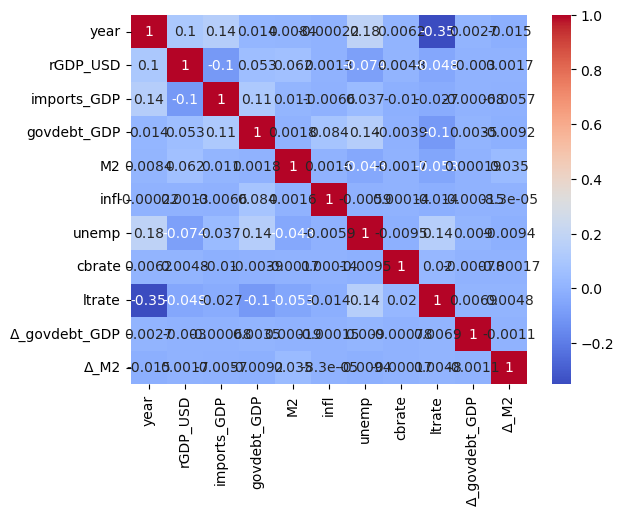

In [105]:
df_filtered_numeric = df_filtered.select_dtypes(include=[np.number])

sns.heatmap(df_filtered_numeric.corr(), annot=True, cmap='coolwarm')
plt.show()

Variables with over |.15| correlation --> Just for inital data exploration
rGDP & importsGDP --> Not surprising: more $, more imports
rGDP & govdebt -> Rich 'exceptionalism', those with bigger economies can afford debt
govdebt & LT_Rate, cbRate, infl --> Not Δ, but this could be important for FTPL
infl & cbrate, lt_rate --> adjusts for value, is expected
unemp & lt_rate --> Postive, expected, following phillips curve


To Do:
Identify Countries as developed or developing 

Identify if the information for consumer sentimenet is 'contained' within all other datapoints
    --> Indexed? Percent Change? normalization?

Scale all variables

Use KNN to determine bins
    --> before or after normalization?

In [ ]:
descriptive_stats = df_filtered_numeric.describe()

In [ ]:
plt.scatter(df_filtered['Δ_govdebt_GDP'], df_filtered['infl'])
plt.xlabel('Δ Government Debt to GDP')
plt.ylabel('Inflation')
plt.title('Inflation vs Δ Government Debt to GDP')
plt.show()

In [ ]:
plt.scatter(df_filtered['unemp'], df_filtered['infl'])
plt.ylabel('infl')
plt.xlabel('unemp')
plt.show()

In [10]:
df_filtered = df_filtered[df_filtered['Δ_M2'] < 400]

In [130]:
df_filtered

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country
159,1959,NaN,NaN,NaN,1758.6630,NaN,NaN,NaN,NaN,NaN,8.070041,Afghanistan
160,1960,10661.190,6.633230,NaN,2016.3607,NaN,NaN,NaN,NaN,NaN,14.653046,Afghanistan
161,1961,10733.063,7.645829,NaN,2223.8816,NaN,NaN,NaN,NaN,NaN,10.291854,Afghanistan
162,1962,10896.182,8.828445,NaN,2620.3396,NaN,NaN,NaN,NaN,NaN,17.827298,Afghanistan
163,1963,11093.813,15.923912,NaN,3028.5676,NaN,NaN,NaN,NaN,NaN,15.579202,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...
56402,2026,NaN,NaN,55.425999,NaN,7.962133,NaN,NaN,NaN,-4.451110,0.000000,Zimbabwe
56403,2027,NaN,NaN,53.108002,NaN,5.759129,NaN,NaN,NaN,-4.182147,0.000000,Zimbabwe
56404,2028,NaN,NaN,52.375000,NaN,5.108962,NaN,NaN,NaN,-1.380210,0.000000,Zimbabwe
56405,2029,NaN,NaN,51.237999,NaN,5.131044,NaN,NaN,NaN,-2.170885,0.000000,Zimbabwe


## Hide


In [ ]:
plt.scatter(df_filtered['Δ_M2'], df_filtered['infl'])   
plt.xlabel('Δ M2')
plt.ylabel('Inflation')
plt.title('Inflation vs Δ M2')
plt.show()

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = df_filtered_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_filtered_numeric.values, i) for i in range(len(df_filtered_numeric.columns))]

vif_data

,Variable,VIF
0,year,10.800455
1,rGDP_USD,1.284973
2,imports_GDP,3.524006
3,govdebt_GDP,3.150366
4,M2,1.056598
5,infl,2.285969
6,unemp,2.952776
7,cbrate,7.862020
8,ltrate,10.956977
9,Δ_govdebt_GDP,1.023034


In [ ]:
df_filtered['countryname'].unique()

In [ ]:
print(df_filtered['countryname'].value_counts(dropna=False).to_string())

In [83]:
total_observations = df_filtered.shape[0]
total_observations

56407

In [ ]:
year_counts = df_filtered['year'].value_counts(dropna=False).sort_index(ascending=False)
print(year_counts.to_string())

In [81]:
df_years = df_filtered[df_filtered['year'] >= 1950]
df_years.shape[0]

1846

In [15]:
print(df_years['countryname'].value_counts(dropna=False).to_string())

NameError: name 'df_years' is not defined

In [16]:
df_filtered['Country'] = df_filtered['countryname']
df_filtered = df_filtered.drop('countryname', axis=1)

# Regression to determine 'Information Inclusion' of Consumer Sentiment

In [11]:
api_key = 'e4bbbd109c546c1661986ae1b4815d17'  
fred = Fred(api_key=api_key)

# Dictionary of countries and their corresponding FRED series IDs for Consumer Confidence
consumer_confidence_series = {
    'Australia': 'CSCICP02AUM460S',
    'United Kingdom': 'CSCICP02GBM460S',
    'Japan': 'CSCICP02JPM460S',
    'Korea': 'CSCICP02KRA066S',
    'New Zealand': 'LOCOCIORNZQ665S',
    'United States': 'USALOCOCINOSTSAM',
    'Canada': 'CSCICP02CAM661N',  
    'Italy': 'CSCICP02ITM460S',
    'Portugal': 'CSCICP02PTM460S',
    'Turkey': 'CSCICP02TRM460S',
    'Brazil': 'CSCICP02BRM460S',
    'Czechia': 'CSCICP02CZM460S',
    'Switzerland': 'CSCICP02CHQ460S',
    'Germany': 'CSCICP02DEM460S',
    'France': 'CSCICP02FRM460S',
    'Mexico': 'CSCICP02MXM460S',
    'Russia': 'RUSCSCICP02STSAQ',
    'Spain': 'CSCICP02ESM460S',
    'Sweden': 'CSCICP02SEM460S',
    'Denmark': 'CSCICP02DKM460S',
    'Netherlands': 'CSCICP02NLM460S',  
    'China': 'CSCICP02CNM460S', 
}


data = {}
for country, series_id in consumer_confidence_series.items():
    data[country] = fred.get_series(series_id)
    
consumer_data = pd.DataFrame(data)


In [12]:
consumer_data_yearly = consumer_data.resample('YE').mean()

consumer_data_yearly.index = consumer_data_yearly.index.year

,Australia,United Kingdom,Japan,Korea,New Zealand,United States,Canada,Italy,Portugal,Turkey,...,Switzerland,Germany,France,Mexico,Russia,Spain,Sweden,Denmark,Netherlands,China
1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.920170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.833333,NaN,NaN,...,-2.890345,-3.916667,10.909091,NaN,NaN,NaN,NaN,NaN,1.583333,NaN
1974,-8.500000,-17.833333,NaN,NaN,NaN,NaN,NaN,-31.500000,NaN,NaN,...,-20.304988,-13.916667,-2.818182,NaN,NaN,NaN,NaN,-13.833333,-7.250000,NaN
1975,5.250000,-25.000000,NaN,NaN,NaN,NaN,NaN,-31.166667,NaN,NaN,...,-27.845190,-4.500000,-2.181818,NaN,NaN,NaN,NaN,-3.250000,-11.666667,NaN
1976,7.416667,-15.250000,NaN,NaN,NaN,NaN,NaN,-31.416667,NaN,NaN,...,-10.991058,5.666667,2.545455,NaN,NaN,NaN,NaN,1.416667,-4.916667,NaN


In [13]:
consumer_data_panel = consumer_data_yearly.reset_index().melt(id_vars='index', var_name='Country', value_name='Consumer_Confidence')
consumer_data_panel.rename(columns={'index': 'Year'}, inplace=True)

consumer_data_panel.dropna(inplace=True)

consumer_data_panel.head()

,Year,Country,Consumer_Confidence
2,1974,Australia,-8.500000
3,1975,Australia,5.250000
4,1976,Australia,7.416667
5,1977,Australia,4.166667
6,1978,Australia,6.916667


In [18]:
merged_df = pd.merge(df_filtered, consumer_data_panel, left_on=['year', 'Country'], right_on=['Year', 'Country'], how='inner')
merged_df.head()

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country,Year,Consumer_Confidence
0,1974,346466.56,13.193513,22.369764,26495.008,15.416663,2.656920,9.00,9.036667,-18.255865,9.158091,Australia,1974,-8.500000
1,1975,355049.81,14.711743,23.640409,31942.154,15.162456,4.878655,8.40,9.741667,5.680190,20.559141,Australia,1975,5.250000
2,1976,368675.72,13.361888,22.985813,35848.285,13.322886,4.749999,7.20,10.030833,-2.768971,12.228765,Australia,1976,7.416667
3,1977,374142.38,14.630217,23.642473,37970.832,12.309813,5.604135,7.91,10.226666,2.856806,5.920916,Australia,1977,4.166667
4,1978,381696.06,14.570860,22.087608,41954.063,8.004933,6.290086,8.28,9.060000,-6.576575,10.490239,Australia,1978,6.916667


In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


columns_to_normalize = merged_df.columns.difference(['year', 'Country'])

#Min-Max scaling
scaler = MinMaxScaler()
merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

   year  rGDP_USD  imports_GDP  govdebt_GDP        M2      infl     unemp  \
0  1974  0.011840     0.078958     0.070982  0.000005  0.228165  0.101771   
1  1975  0.012231     0.097735     0.075983  0.000008  0.224717  0.186916   
2  1976  0.012851     0.081040     0.073407  0.000011  0.199760  0.181985   
3  1977  0.013099     0.096727     0.075992  0.000012  0.186016  0.214719   
4  1978  0.013443     0.095993     0.069871  0.000015  0.127613  0.241007   

     cbrate    ltrate  Δ_govdebt_GDP      Δ_M2    Country      Year  \
0  0.202073  0.399762       0.127795  0.258083  Australia  0.037736   
1  0.189637  0.429240       0.205016  0.342858  Australia  0.056604   
2  0.164767  0.441332       0.177758  0.280916  Australia  0.075472   
3  0.179482  0.449520       0.195907  0.234013  Australia  0.094340   
4  0.187150  0.400737       0.165474  0.267989  Australia  0.113208   

   Consumer_Confidence  
0             0.205091  
1             0.285979  
2             0.298725  
3         

In [21]:
print(len(merged_df))

783


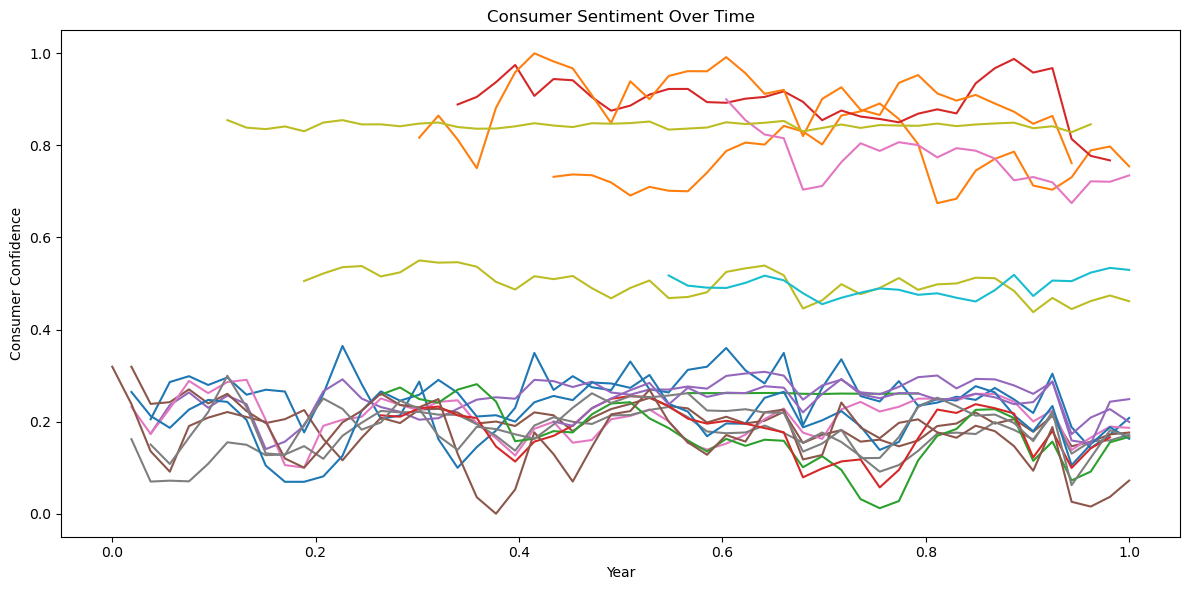

In [23]:
plt.figure(figsize=(12, 6))
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['Consumer_Confidence'], label=country)

plt.xlabel('Year')
plt.ylabel('Consumer Confidence')
plt.title('Consumer Sentiment Over Time')
plt.tight_layout()
plt.show()

In [24]:
merged_df['Consumer_Confidence_Indexed'] = merged_df['Consumer_Confidence'].pct_change() * 100
merged_df.head()

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country,Year,Consumer_Confidence,Consumer_Confidence_Indexed
0,1974,0.011840,0.078958,0.070982,0.000005,0.228165,0.101771,0.202073,0.399762,0.127795,0.258083,Australia,0.037736,0.205091,NaN
1,1975,0.012231,0.097735,0.075983,0.000008,0.224717,0.186916,0.189637,0.429240,0.205016,0.342858,Australia,0.056604,0.285979,39.440071
2,1976,0.012851,0.081040,0.073407,0.000011,0.199760,0.181985,0.164767,0.441332,0.177758,0.280916,Australia,0.075472,0.298725,4.456968
3,1977,0.013099,0.096727,0.075992,0.000012,0.186016,0.214719,0.179482,0.449520,0.195907,0.234013,Australia,0.094340,0.279606,-6.400197
4,1978,0.013443,0.095993,0.069871,0.000015,0.127613,0.241007,0.187150,0.400737,0.165474,0.267989,Australia,0.113208,0.295784,5.785858


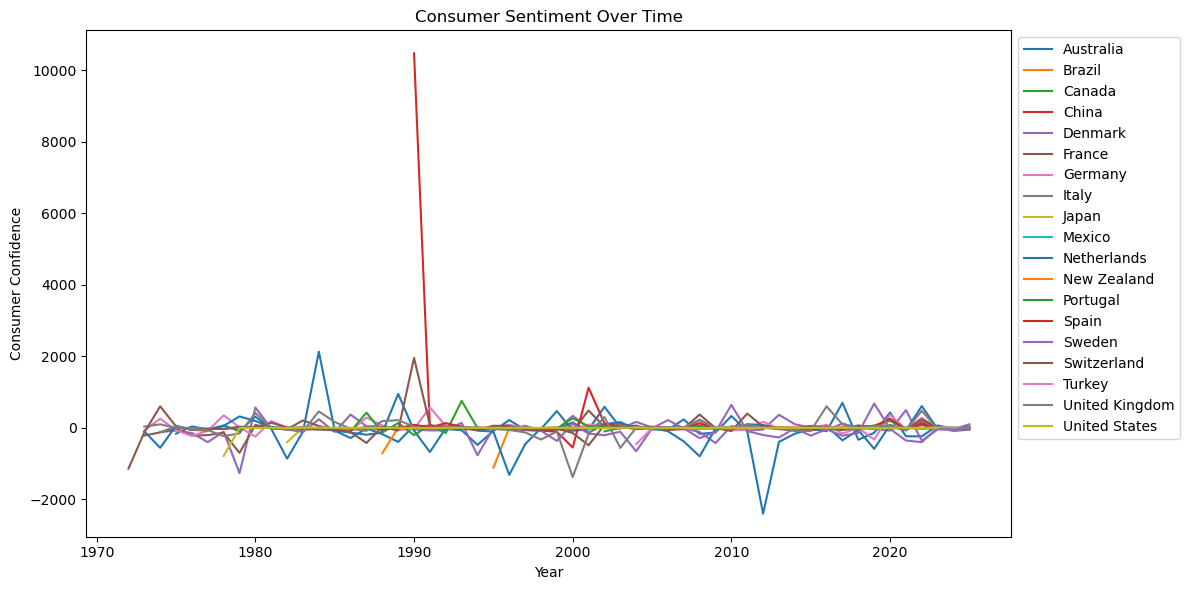

In [126]:
plt.figure(figsize=(12, 6))
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['Consumer_Confidence_Indexed'], label=country)

plt.xlabel('Year')
plt.ylabel('Consumer Confidence')
plt.title('Consumer Sentiment Over Time')
plt.tight_layout()
plt.show()

In [25]:
X = merged_df.drop(columns=['Country', 'Year', 'Consumer_Confidence', 'Consumer_Confidence_Indexed'])
y = merged_df['Consumer_Confidence_Indexed']
X = X.dropna()
y = y.loc[X.index]
y = y.dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(mse)
print(r2)

ValueError: Input y contains NaN.

# Causal Forest

In [139]:
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

In [140]:
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [145]:
df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)  
df_filtered.dropna(inplace=True)  
#df_filtered.fillna(df_filtered.mean(), inplace=True) 

In [157]:
Y = df_filtered['infl']
T= df_filtered['infl']
scaler = StandardScaler()
W1 = scaler.fit_transform(df_filtered[['imports_GDP', 'Δ_govdebt_GDP', 'Δ_M2', 'cbrate', 'ltrate', 'rGDP_USD']])
X = df_filtered[['unemp']]

In [151]:
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [160]:
est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
                        model_t=WeightedLasso(alpha=0.01),
                        discrete_treatment=False,
                        n_estimators=n_trees,
                        min_samples_leaf=min_leaf_size,
                        max_depth=max_depth,
                        random_state=123)

est.fit(Y,T,X=X, W=W1)

Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x311027f50> has a non-default cv attribute, which will be ignored


In [161]:
min_unemp = X.min().values[0]  
max_unemp = X.max().values[0]  
delta = (max_unemp - min_unemp) / 100  
X_test = np.arange(min_unemp, max_unemp + delta - 0.001, delta).reshape(-1, 1)

treatment_effects = est.effect(X_test)



In [135]:
help(CausalForestDML)

Help on class CausalForestDML in module econml.dml.causal_forest:

class CausalForestDML(econml.dml.dml._BaseDML)
 |  CausalForestDML(*, model_y='auto', model_t='auto', featurizer=None, treatment_featurizer=None, discrete_outcome=False, discrete_treatment=False, categories='auto', cv=2, mc_iters=None, mc_agg='mean', drate=True, n_estimators=100, criterion='mse', max_depth=None, min_samples_split=10, min_samples_leaf=5, min_weight_fraction_leaf=0.0, min_var_fraction_leaf=None, min_var_leaf_on_val=False, max_features='auto', min_impurity_decrease=0.0, max_samples=0.45, min_balancedness_tol=0.45, honest=True, inference=True, fit_intercept=True, subforest_size=4, n_jobs=-1, random_state=None, verbose=0, allow_missing=False, use_ray=False, ray_remote_func_options=None)
 |  
 |  A Causal Forest [cfdml1]_ combined with double machine learning based residualization of the treatment
 |  and outcome variables. It fits a forest that solves the local moment equation problem:
 |  
 |  .. code-block

In [168]:
bin_edges = [-np.inf,0, 5, 20, 50, np.inf]  # Inflation bin ranges
bin_labels = ['Disinflation', 'Target', 'Moderate', 'High','Hyperinflation']  # Inflation bin labels
df_filtered['inflation_bin'] = pd.cut(df_filtered['infl'], bins=bin_edges, labels=bin_labels)

X_knn = df_filtered[['imports_GDP', 'Δ_govdebt_GDP', 'Δ_M2', 'unemp', 'cbrate', 'ltrate', 'rGDP_USD']]
Y_knn = df_filtered['inflation_bin']

label_encoder = LabelEncoder()
Y_knn_encoded = label_encoder.fit_transform(Y_knn)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_knn, Y_knn_encoded)

df_filtered['knn_pred_bin'] = knn_model.predict(X_knn)


In [169]:
from sklearn.ensemble import RandomForestRegressor

X_rf = df_filtered[['imports_GDP', 'Δ_govdebt_GDP', 'Δ_M2', 'unemp', 'cbrate', 'ltrate', 'rGDP_USD', 'knn_pred_bin']]
Y_rf = df_filtered['infl']

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X_rf, Y_rf, test_size=0.2, random_state=123)

rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_leaf=10, random_state=123)
rf_model.fit(X_train, Y_train)

Y_pred = rf_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(mse)
print(r2)


Mean Squared Error: 17.528
R² Score: 0.555


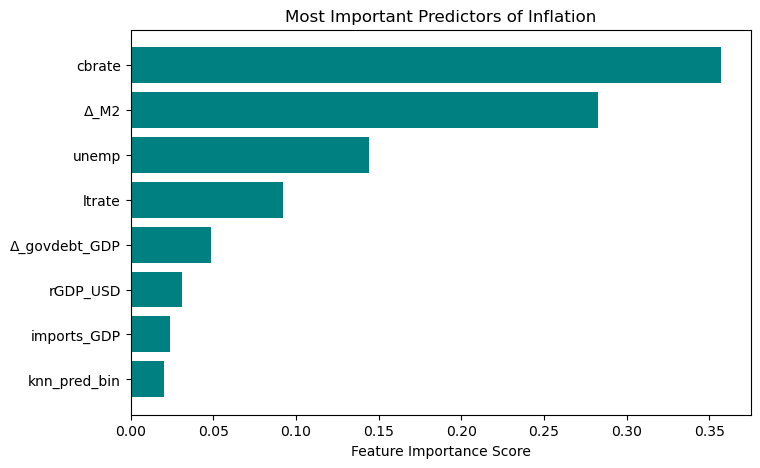

In [170]:
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(X_rf.columns[sorted_idx], importances[sorted_idx], color="teal")
plt.xlabel("Feature Importance Score")
plt.title("Most Important Predictors of Inflation")
plt.show()


--> Not sure if this is ok, cbrate is often reactive...
--> KNN_pred_bin also is peculiar

In [ ]:
from sklearn.tree import plot_tree


In [ ]:
plt.figure(figsize=(15, 8))
plot_tree(rf_model.estimators_[0], feature_names=X.columns, filled=True, rounded=True)
plt.title("Sample Decision Tree from the Random Forest")
plt.show()